# Linear Gaussian test  
deismic

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sbi.simulators as simulators
import sbi.utils as utils
import torch
from sbi.inference.snpe.snpe_c import APT
from torch import distributions

# use cpu by default
torch.set_default_tensor_type("torch.FloatTensor")

# seed the simulations
torch.manual_seed(0)

## Create NN instance

In [3]:
dim, std = 3, 0.5
simulator = simulators.LinearGaussianSimulator(dim=dim, std=std)
prior = distributions.MultivariateNormal(loc=torch.zeros(dim), covariance_matrix=torch.eye(dim))

In [4]:
ground_truth_parameters = prior.sample()
true_observation = simulator(ground_truth_parameters) 

In [5]:
neural_posterior = utils.get_sbi_posterior(
    model='maf',
    prior=prior,
    context=true_observation,
)

/home/michael/Documents/nflows-pr/nflows/transforms/standard.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "_shift", torch.tensor(shift if (shift is not None) else 0.0)
/home/michael/Documents/nflows-pr/nflows/transforms/standard.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "_scale", torch.tensor(scale if (scale is not None) else 1.0)


In [6]:
apt = APT(
    simulator=simulator,
    true_observation=true_observation,
    prior=prior,
    density_estimator=neural_posterior,
    num_atoms=-1,
    z_score_obs=True,
    use_combined_loss=False,
    retrain_from_scratch_each_round=False,
    discard_prior_samples=False,
)

### Run inference

In [7]:
num_rounds, num_simulations_per_round = 1, 2000
apt.run_inference(
    num_rounds=num_rounds, num_simulations_per_round=num_simulations_per_round
)

  0%|          | 0/1 [00:00<?, ?it/s]/home/michael/anaconda3/envs/sbi/lib/python3.8/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
100%|██████████| 1/1 [00:31<00:00, 31.00s/it]


### Draw samples and plot hist

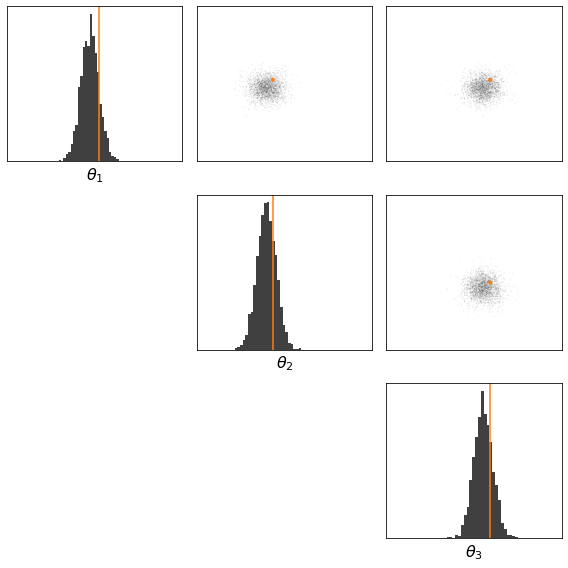

In [8]:
samples = apt._neural_posterior.sample(2500)
samples = utils.tensor2numpy(samples)
figure = utils.plot_hist_marginals(
    data=samples,
    ground_truth=utils.tensor2numpy(
        ground_truth_parameters
    ).reshape(-1),
    lims=[-4, 4],
)